<a href="https://colab.research.google.com/github/TheAmirHK/EnergyOptimization_projects/blob/main/WindSolarGeneration_predictor(can_be_better).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# load dataset
df = pd.read_csv("renewable_thermal_energy_data.csv", parse_dates=["Timestamp"], index_col="Timestamp")

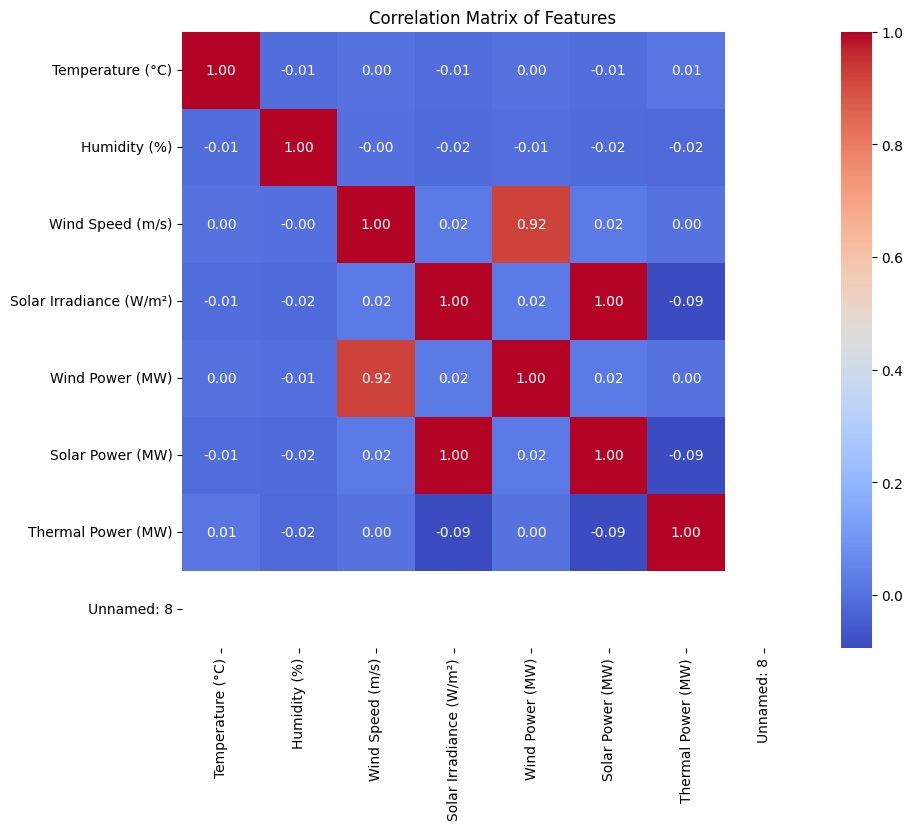

In [22]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# *** observation: with this dataset we do not observe any correlation between any feature and thermal. so we cannot predict the thermal power output unfortunatley !
# drop the irrelevant columns
df = df.drop(['Thermal Power (MW)', 'Unnamed: 8'], axis=1)

In [23]:
# Select features and target variables
features = ["Temperature (°C)", "Humidity (%)", "Wind Speed (m/s)", "Solar Irradiance (W/m²)"]
targets = ["Wind Power (MW)", "Solar Power (MW)"]

Mean Squared Error: 0.00012396169805936215


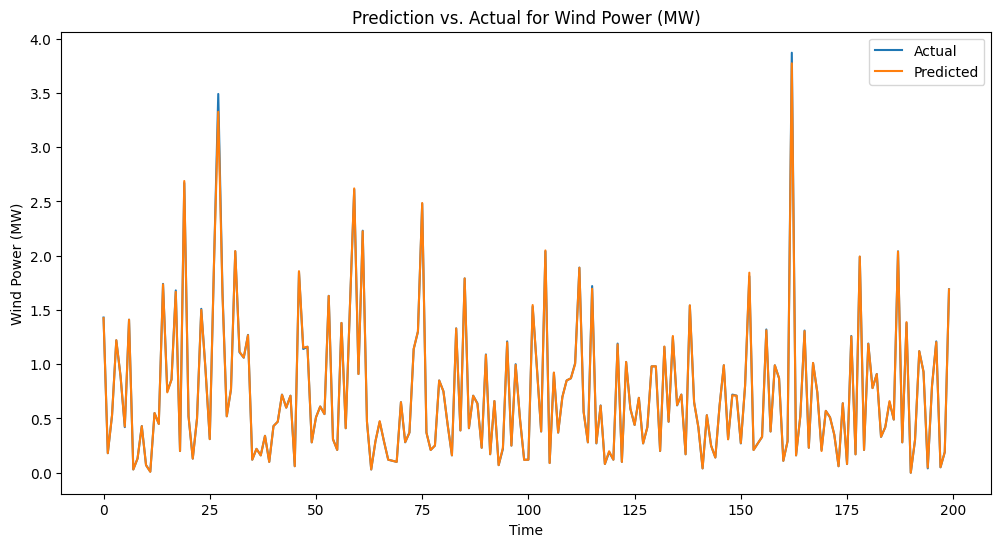

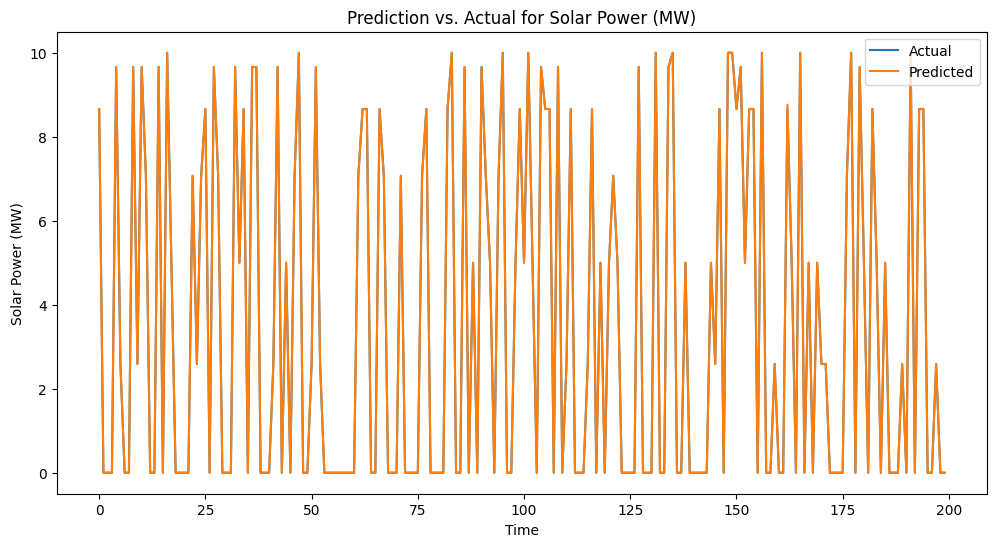

In [71]:
# In[random forest model]
X = df[features]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

y_test = y_test.reset_index(drop=True)
y_pred = pd.DataFrame(y_pred, columns=targets)

for target in targets:
  plt.figure(figsize=(12, 6))
  plt.plot(y_test[target][:200], label="Actual")
  plt.plot(y_pred[target][:200], label="Predicted")
  plt.title(f"Prediction vs. Actual for {target}")
  plt.xlabel("Time")
  plt.ylabel(target)
  plt.legend()
  plt.show()

In [72]:
# [prepare data]
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

num_features = len(features)
num_targets = len(targets)

sequence_length = 24
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i:i+sequence_length,:num_features])
    y.append(df_scaled[i+sequence_length, num_features:])
X, y = np.array(X), np.array(y)

In [ ]:
# In[LSTM model]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lstm_model = Sequential([
    LSTM(128,activation='relu', return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='linear')])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=50, validation_data=(X_test, y_test))

In [ ]:
# In[GRU model]
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32, return_sequences=True),
    Dropout(0.2),
    GRU(16, return_sequences=False),
    Dropout(0.2),
    Dense(2, activation='linear')])

gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, batch_size=50, validation_data=(X_test, y_test))

In [107]:
# In[next hour's energy prediction]
y_pred = lstm_model.predict(X_test)

tra_pred = np.zeros((y_pred.shape[0], num_features + num_targets))
tra_pred[:, :num_features] = X_test[:, -1, :num_features]
tra_pred[:, num_features:] = y_pred
y_pred_original = scaler.inverse_transform(tra_pred)[:, -num_targets:]

tra_actual = np.zeros((y_test.shape[0], num_features + num_targets))
tra_actual[:, :num_features] = X_test[:, -1, :num_features]
tra_actual[:, num_features:] = y_test
y_test_original = scaler.inverse_transform(tra_actual)[:, -num_targets:]

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


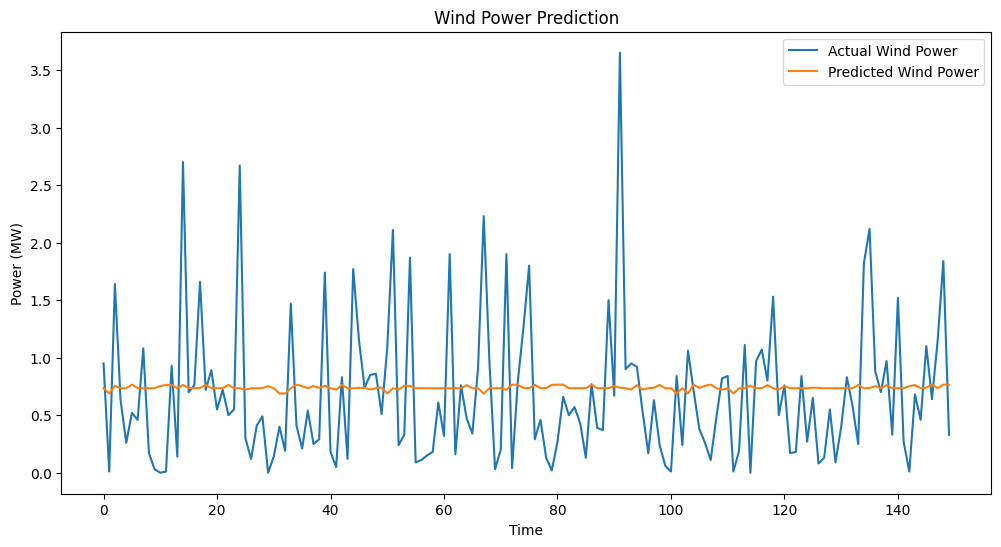

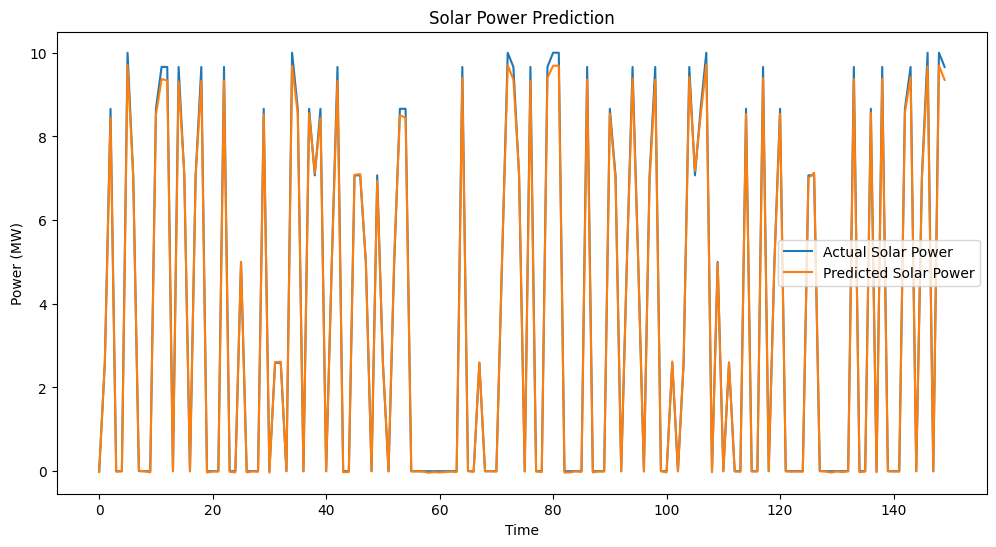

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:150, 0], label='Actual Wind Power')
plt.plot(y_pred_original[:150, 0], label='Predicted Wind Power')
plt.title('Wind Power Prediction')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:150, 1], label='Actual Solar Power')
plt.plot(y_pred_original[:150, 1], label='Predicted Solar Power')
plt.title('Solar Power Prediction')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.show()